In [1]:
from transformers import AutoTokenizer
import torch 
import joblib 
import numpy as np
import pickle
import string
import os
import re
import glob
from torch.nn import functional as F
from scipy.spatial.distance import hamming
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import natsort
import seaborn as sns
from natsort import os_sorted
import sys
from scipy import stats
sys.path.append('/home/jianing/generation/Memory_generation')
from utils import calculate_cross_entropy,normalize_entropy,model_to_path_dict

from statsmodels.graphics.factorplots import interaction_plot
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
import sys
sys.path.append('/home/jianing/generation/Memory_generation')
from utils import get_segmentation_indices,segmentation_to_word_list

def story_segmentation_indices(story,model):
    segmentation_dir=os.path.join('/home/jianing/generation/behavior_data/segmentation',story)
    consensus_path = os.path.join(segmentation_dir,'%s_consensus.txt'%story)
    original_transcript_dir = '/home/jianing/generation/transcripts/moth_stories'
    with open(consensus_path,'r') as f:
        consensus_txt = f.read()
    consensus_txt = consensus_txt.split('\n')
    consensus_wordlist = segmentation_to_word_list(consensus_txt)

    with open(os.path.join(original_transcript_dir,'%s.txt'%story),'r') as f:
        original_txt = f.read()

    # load story tokens
    tokens_dir = os.path.join('/home/jianing/generation/generated',model,'moth_stories_output')
    story_tokens = torch.load(os.path.join(tokens_dir,story,'tokens.pkl')) # this contains BOS token
    with open(os.path.join(tokens_dir,story,'tokenized_txt.pkl'),'rb') as f:
        tokenized_txt = pickle.load(f)
    with open(os.path.join(tokens_dir,story,'cross_entropy.pkl'),'rb') as f:
        story_ce = pickle.load(f)
    # humans segment after this token index in tokenized_txt
    segmentation_indices_in_tokens = get_segmentation_indices(tokenized_txt,consensus_wordlist,original_txt,initial_char='Ġ')
    assert segmentation_indices_in_tokens[-1] == len(tokenized_txt)-1,'last segmentation index in token must be the last token'
    return segmentation_indices_in_tokens

In [4]:
model_name = 'Llama3-8b-instruct'
model_save_dir_name = model_to_path_dict[model_name]['save_dir_name']
model_initial_char = model_to_path_dict[model_name]['initial_char']
tokenizer = AutoTokenizer.from_pretrained(model_to_path_dict[model_name]['hf_name'])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
stories = ['pieman','alternateithicatom','odetostepfather','adventuresinsayingyes','inamoment','legacy','souls','wheretheressmoke']
story_segmentation_indices_dict = {}
for story in stories:
    story_segmentation_indices_dict[story] = story_segmentation_indices(story,model_save_dir_name)

In [6]:
event_len_dict = {}
max_range_dict={}
for story in stories:
    event_indices = [0] + story_segmentation_indices_dict[story]
    event_len_dict[story]= np.diff(event_indices)
    mean_len = np.mean(event_len_dict[story])
    std_len = np.std(event_len_dict[story])


In [7]:
def get_log_spacing(max_len,num = 6):
    range_log_spacing = np.logspace(0,np.log10(max_len),num = num)
    range_log_spacing = np.round(range_log_spacing).astype(int)
    include_ranges = []
    for i,spacing in enumerate(range_log_spacing):
        if i==0:
            continue
        elif i==1:
            include_ranges.append((0,spacing))
        else:
            prev_spacing = range_log_spacing[i-1]
            include_ranges.append((prev_spacing,spacing))
    return include_ranges

In [8]:
moth_sliding_window_ablation_dir = os.path.join('/home/jianing/generation/ablation',model_save_dir_name,'sliding_window_ablation/moth_stories')
moth_output_dir = os.path.join('/home/jianing/generation/generated',model_save_dir_name,'moth_stories_output')
if not os.path.exists(moth_sliding_window_ablation_dir):
    os.makedirs(moth_sliding_window_ablation_dir)

### only count as within event when the range of tokens starting from the end of ablation is all within an event 

In [9]:
def parse_entropy_ablation2_range_by_boundary(tokens,ablation_entropy,ablation_stim,cross_entropy_original=None,cross_entropy_normalized = None,normalize = False,word_initial = False,word_initial_bool = None,include_range = None,segmentation_indices = None,num_ablated_in_event = 1):
    '''
    Allows to calculate post-ablation future entropy for different ranges.
    include_range: tuple of [start,end)
    num_ablated_in_event: if = 1, then the within event range starts counting from last token of ablation to end of range. 
        If >1, then it starts counting from last token of ablation-num_ablated_in_event
    '''
    all_mean_original_future_entropy_pertoken = []
    all_mean_ablated_future_entropy_pertoken = []
    all_mean_diff_future_entropy_pertoken = []
    all_ablation_start_indices = []
    ablation_count_within = 0 # number of ablations for each token within event 
    ablation_count_acrossone = 0 # number of ablations for each token 
    entropy_diff_within = [] # mean of change in entropy when the range of future tokens are within the same event 
    entropy_diff_acrossone = [] # mean of change in entropy when the range of future tokens are cross one event boundary
    event_ends = np.array(segmentation_indices[:-1]) # drop the last one (end of story)
    event_starts = event_ends+1


    for count,ablated_entropy in enumerate(ablation_entropy):
        # unablated entropy
        startindex_in_original = ablation_stim['future_index_start_in_original'][count]
        if normalize:
            original_future_entropy = cross_entropy_normalized[startindex_in_original:]
        else:
            original_future_entropy = cross_entropy_original[startindex_in_original:]
            
        # calculate entropy of ablated tokens 
        post_ablation_tokens = ablation_stim['post_ablation_tokens'][count][1:] # get rid of bos 
        startindex_in_ablated = ablation_stim['future_index_start_in_ablated'][count]
        ablated_token_len = ablation_stim['ablated_token_len'][count]
        ablation_start_index = ablation_stim['ablation_start_indices'][count]
        
        end_of_ablation = ablation_start_index+ablated_token_len
        start_of_range = end_of_ablation+min(include_range)
        end_of_range = end_of_ablation+max(include_range)
        in_tokens = np.arange(ablation_start_index,ablation_start_index+ablated_token_len) # ablated tokens
        
        # within event: no event boundary between the last ablated token till end of range 
        # across 1 boundary: 1 event boundary between end of ablation till start of range, and no boundary between start of range to end of range
        within_include_indices = np.arange(end_of_ablation-num_ablated_in_event,end_of_range)
        between_include_indices = np.arange(end_of_ablation,start_of_range)
        range_include_indices = np.arange(start_of_range,end_of_range)
        if np.sum(np.isin(event_ends,within_include_indices))>1 or np.sum(np.isin(event_starts,within_include_indices))>1:
            continue
            
        #print(post_ablation_tokens.shape,ablated_entropy.shape)
        if normalize:
            normalized_ablated_entropy = normalize_entropy(post_ablation_tokens,ablated_entropy,mean_token_cross_entropy,verbose = True)
            assert np.sum(np.isnan(normalized_ablated_entropy))==0
            ablated_future_entropy = normalized_ablated_entropy[startindex_in_ablated:]
        else:
            ablated_future_entropy = ablated_entropy[startindex_in_ablated:]
        assert original_future_entropy.shape == ablated_future_entropy.shape
         
        if include_range[1]<= original_future_entropy.shape[0]:
            original_future_entropy = original_future_entropy[include_range[0]:include_range[1]]
            ablated_future_entropy = ablated_future_entropy[include_range[0]:include_range[1]]
        else:
            continue
        assert original_future_entropy.shape[0] > 0
        
        if word_initial == True: # only include word initial tokens 
            future_word_initial_bool = word_initial_bool[startindex_in_original:]
            future_word_initial_bool = future_word_initial_bool[include_range[0]:include_range[1]]
            assert original_future_entropy.shape[0] == len(future_word_initial_bool)
            original_future_entropy = original_future_entropy[future_word_initial_bool]
            ablated_future_entropy = ablated_future_entropy[future_word_initial_bool]
            if len(original_future_entropy)==0:
                continue
        if not isinstance(original_future_entropy,np.ndarray):
            mean_original_future_entropy_pertoken = np.mean(original_future_entropy.numpy())
            mean_ablated_future_entropy_pertoken = np.mean(ablated_future_entropy.numpy())
        else:
            mean_original_future_entropy_pertoken = np.mean(original_future_entropy)
            mean_ablated_future_entropy_pertoken = np.mean(ablated_future_entropy)
        diff_future_entropy_pertoken = mean_ablated_future_entropy_pertoken-mean_original_future_entropy_pertoken
        assert not np.isnan(diff_future_entropy_pertoken)

        if np.sum(np.isin(event_ends,within_include_indices))==0 and np.sum(np.isin(event_starts,within_include_indices))==0:
            entropy_diff_within.append(diff_future_entropy_pertoken)
            ablation_count_within+=1
        # the gap between end of ablation and start of range has to include both the end of and event and start of next to qualify as crossing a boundary
        elif np.sum(np.isin(event_ends,between_include_indices))==1 and np.sum(np.isin(event_starts,between_include_indices))==1:
            # and the range itself should not have a boundary in it
            if np.sum(np.isin(event_ends,range_include_indices))==0 and np.sum(np.isin(event_starts,range_include_indices))==0:
                entropy_diff_acrossone.append(diff_future_entropy_pertoken)
                ablation_count_acrossone+=1

        # append 
        all_mean_original_future_entropy_pertoken.append(mean_original_future_entropy_pertoken)
        all_mean_ablated_future_entropy_pertoken.append(mean_ablated_future_entropy_pertoken)
        all_mean_diff_future_entropy_pertoken.append(diff_future_entropy_pertoken)
        all_ablation_start_indices.append(ablation_start_index)
            
    all_mean_original_future_entropy_pertoken = np.array(all_mean_original_future_entropy_pertoken)
    all_mean_ablated_future_entropy_pertoken = np.array(all_mean_ablated_future_entropy_pertoken)
    all_mean_diff_future_entropy_pertoken = np.array(all_mean_diff_future_entropy_pertoken)
    all_ablation_start_indices = np.array(all_ablation_start_indices)
    entropy_diff_within = np.array(entropy_diff_within) 
    entropy_diff_acrossone = np.array(entropy_diff_acrossone) 


    return all_mean_original_future_entropy_pertoken,all_mean_ablated_future_entropy_pertoken,all_mean_diff_future_entropy_pertoken,all_ablation_start_indices,entropy_diff_within,entropy_diff_acrossone,ablation_count_within,ablation_count_acrossone

In [55]:
nbins = 5
include_ranges_dict3 = {} # max include range = mean + std
include_ranges_dict3plus = {}
include_ranges_dict3minus = {}
for story in stories:
    event_indices = [0] + story_segmentation_indices_dict[story]
    mean_len = np.mean(event_len_dict[story])
    std_len = np.std(event_len_dict[story])
    median_len = np.median(event_len_dict[story])
    print(mean_len,median_len,std_len)
    bins = get_log_spacing(int(np.round(mean_len+std_len)),num = nbins+1)
    include_ranges_dict3[story] = bins
    include_ranges_dict3plus[story] = np.array(bins) + 3
    include_ranges_dict3minus[story] = np.array(bins)[3:] -3
    #include_ranges_dict3[story] = get_log_spacing(int(np.round(mean_len)),num = 6)

86.08333333333333 57.5 72.62972111256444
111.23809523809524 59.0 113.21740769817904
101.89285714285714 85.0 89.38134164742593
95.2 53.0 176.52285970944385
83.83333333333333 72.5 40.64446115059495
94.76190476190476 51.0 89.96872724500535
108.77777777777777 86.5 86.0029428149962
115.17647058823529 74.0 138.4720125870069


In [56]:
include_ranges_dict3

{'pieman': [(0, 3), (3, 8), (8, 21), (21, 58), (58, 159)],
 'alternateithicatom': [(0, 3), (3, 9), (9, 26), (26, 76), (76, 224)],
 'odetostepfather': [(0, 3), (3, 8), (8, 23), (23, 67), (67, 191)],
 'adventuresinsayingyes': [(0, 3), (3, 9), (9, 29), (29, 89), (89, 272)],
 'inamoment': [(0, 3), (3, 7), (7, 18), (18, 47), (47, 124)],
 'legacy': [(0, 3), (3, 8), (8, 23), (23, 65), (65, 185)],
 'souls': [(0, 3), (3, 8), (8, 24), (24, 68), (68, 195)],
 'wheretheressmoke': [(0, 3), (3, 9), (9, 28), (28, 84), (84, 254)]}

In [57]:
results_save_dir = os.path.join('/home/jianing/generation/ablation',model_save_dir_name,'sliding_window_ablation','aggregated_results')
if not os.path.exists(os.path.join(results_save_dir,'results_dict_%sbins.pkl'%nbins)):
    with open(os.path.join('/home/jianing/generation/generated',model_save_dir_name,'mean_token_ce_dict_moth_only.pkl'),'rb') as f:
        mean_token_cross_entropy = pickle.load(f)

    num_ablated_in_event = 1

    # average CE change when each token is ablated 
    token_entropy_diff_within_dict = {}
    token_entropy_diff_acrossone_dict = {}
    normalized_token_entropy_diff_within_dict = {}
    normalized_token_entropy_diff_acrossone_dict = {}
    token_ablation_count_within_dict = {}
    token_ablation_count_acrossone_dict = {}


    for story in tqdm(stories): 
        #print(story)
        include_ranges = include_ranges_dict3[story]
        story_stim_dir = os.path.join(moth_sliding_window_ablation_dir,story)
        ablation_ce_path = os.path.join(story_stim_dir,'ablation_logits','ablation_cross_entropy_count_balanced.pkl')
        if os.path.exists(ablation_ce_path):
            with open(ablation_ce_path,'rb') as f:
                ablation_cross_entropy_count_balanced = pickle.load(f)
        else:
            continue
        with open(os.path.join(story_stim_dir,'ablation_stim_count_balanced.pkl'),'rb') as f:
            story_ablation_stim = pickle.load(f)

        story_tokens = torch.load(os.path.join(moth_output_dir,story,'tokens.pkl'))[0,1:]
        with open(os.path.join(moth_output_dir,story,'cross_entropy.pkl'),'rb') as f:
            story_cross_entropy = pickle.load(f)
        with open(os.path.join(moth_output_dir,story,'tokenized_txt.pkl'),'rb') as f:
            story_tokenized_txt = pickle.load(f)

        word_initial_bool = [True if model_to_path_dict[model_name]['initial_char'] in t else False for t in story_tokenized_txt]
        story_normalized_cross_entropy = normalize_entropy(story_tokens,story_cross_entropy,mean_token_cross_entropy,verbose = False)

        segmentation_indices = story_segmentation_indices_dict[story]

        all_mean_token_entropy_diff_within = []
        all_mean_token_entropy_diff_acrossone = []
        all_mean_token_entropy_diff_within_normalized = []
        all_mean_token_entropy_diff_acrossone_normalized = []
        all_ablation_count_within = []
        all_ablation_count_acrossone = []
        all_distance_to_eor_within = []
        all_distance_to_eor_acrossone = []
        for include_range in include_ranges:
            _,_,_,_,this_mean_token_entropy_diff_within,this_mean_token_entropy_diff_acrossone,ablation_count_within,ablation_count_acrossone = parse_entropy_ablation2_range_by_boundary(story_tokens,ablation_cross_entropy_count_balanced,story_ablation_stim,story_cross_entropy,normalize = False,include_range = include_range,segmentation_indices=segmentation_indices,num_ablated_in_event = num_ablated_in_event)
            _,_,_,_,this_mean_token_entropy_diff_within_normalized,this_mean_token_entropy_diff_acrossone_normalized,ablation_count_within,ablation_count_acrossone = parse_entropy_ablation2_range_by_boundary(story_tokens,ablation_cross_entropy_count_balanced,story_ablation_stim,cross_entropy_normalized = story_normalized_cross_entropy,normalize = True,word_initial = True,word_initial_bool=word_initial_bool,include_range = include_range,segmentation_indices=segmentation_indices,num_ablated_in_event=num_ablated_in_event)
            #_,_,_,_,this_mean_token_entropy_diff_within_normalized,this_mean_token_entropy_diff_acrossone_normalized,ablation_count_within,ablation_count_acrossone = parse_entropy_ablation2_range_by_boundary(story_tokens,ablation_cross_entropy_count_balanced,story_ablation_stim,cross_entropy_normalized = story_normalized_cross_entropy,normalize = True,include_range = include_range,segmentation_indices=segmentation_indices)
            all_mean_token_entropy_diff_within.append(this_mean_token_entropy_diff_within)
            all_mean_token_entropy_diff_acrossone.append(this_mean_token_entropy_diff_acrossone)
            all_mean_token_entropy_diff_within_normalized.append(this_mean_token_entropy_diff_within_normalized)
            all_mean_token_entropy_diff_acrossone_normalized.append(this_mean_token_entropy_diff_acrossone_normalized)
            all_ablation_count_within.append(ablation_count_within)
            all_ablation_count_acrossone.append(ablation_count_acrossone)


        token_entropy_diff_within_dict[story] = all_mean_token_entropy_diff_within
        token_entropy_diff_acrossone_dict[story] = all_mean_token_entropy_diff_acrossone
        normalized_token_entropy_diff_within_dict[story] = all_mean_token_entropy_diff_within_normalized
        normalized_token_entropy_diff_acrossone_dict[story] = all_mean_token_entropy_diff_acrossone_normalized
        token_ablation_count_within_dict[story] = all_ablation_count_within
        token_ablation_count_acrossone_dict[story] = all_ablation_count_acrossone
    all_results_dict = {'token_entropy_diff_within_dict':token_entropy_diff_within_dict,
                   'token_entropy_diff_acrossone_dict':token_entropy_diff_acrossone_dict,
                   'normalized_token_entropy_diff_within_dict':normalized_token_entropy_diff_within_dict,
                   'normalized_token_entropy_diff_acrossone_dict':normalized_token_entropy_diff_acrossone_dict,
                   'token_ablation_count_within_dict':token_ablation_count_within_dict,
                   'token_ablation_count_acrossone_dict':token_ablation_count_acrossone_dict,
                   'include_ranges':include_ranges_dict3}
    results_save_dir = os.path.join('/home/jianing/generation/ablation',model_save_dir_name,'sliding_window_ablation','aggregated_results')
    with open(os.path.join(results_save_dir,'results_dict_%sbins.pkl'%nbins),'wb') as f:
        pickle.dump(all_results_dict,f)
else:
    with open(os.path.join(results_save_dir,'results_dict_%sbins.pkl'%nbins),'rb') as f:
        all_results_dict = pickle.load(f)
    token_entropy_diff_within_dict = all_results_dict['token_entropy_diff_within_dict']
    token_entropy_diff_acrossone_dict = all_results_dict['token_entropy_diff_acrossone_dict']
    normalized_token_entropy_diff_within_dict = all_results_dict['normalized_token_entropy_diff_within_dict']
    normalized_token_entropy_diff_acrossone_dict = all_results_dict['normalized_token_entropy_diff_acrossone_dict']
    token_ablation_count_within_dict = all_results_dict['token_ablation_count_within_dict']
    token_ablation_count_acrossone_dict = all_results_dict['token_ablation_count_acrossone_dict']

In [58]:
data_dfs = {} # raw CE
data_dfs_norm = {} # normalized CE 
ttest_pvals = {} # pvalues of CE
ttest_pvals_norm = {} # pvalues of normalized CE
for story in tqdm(stories):
    print(story)
    include_ranges = include_ranges_dict3[story]
    story_ablation_within_values = token_entropy_diff_within_dict[story]
    story_ablation_acrossone_values = token_entropy_diff_acrossone_dict[story]
    story_ablation_within_values_norm = normalized_token_entropy_diff_within_dict[story]
    story_ablation_acrossone_values_norm = normalized_token_entropy_diff_acrossone_dict[story]
    story_ablation_count_within = token_ablation_count_within_dict[story]
    story_ablation_count_acrossone = token_ablation_count_acrossone_dict[story]
    
    anova_data = []
    anova_data_norm = []
    pvals = []
    pvals_norm = [ ]
    for i in range(len(include_ranges)):
        this_range = include_ranges[i]
        print(this_range)
        range_boundary_within = story_ablation_within_values[i]
        range_boundary_acrossone = story_ablation_acrossone_values[i]
        range_boundary_within_norm = story_ablation_within_values_norm[i]
        range_boundary_acrossone_norm = story_ablation_acrossone_values_norm[i]
        range_ablation_count_within = story_ablation_count_within[i]
        range_ablation_count_acrossone = story_ablation_count_acrossone[i]
        
        if len(range_boundary_within) > 1 and len(range_boundary_acrossone) > 1:
            for value in range_boundary_within:
                anova_data.append([this_range, 'within', value])
            for value in range_boundary_acrossone:
                anova_data.append([this_range, 'acrossone', value])
            for value in range_boundary_within_norm:
                anova_data_norm.append([this_range, 'within', value])
            for value in range_boundary_acrossone_norm:
                anova_data_norm.append([this_range, 'acrossone', value])

        
        if len(range_boundary_within) > 1 and len(range_boundary_acrossone) > 1:
            print('within-acrossone mean ',np.mean(range_boundary_within)-np.mean(range_boundary_acrossone))
            ttest_result = stats.ttest_ind(range_boundary_within,range_boundary_acrossone,equal_var = False)
            print('cross entropy t-test',ttest_result)
            print('within-acrossone mean normalized',np.mean(range_boundary_within_norm)-np.mean(range_boundary_acrossone_norm))
            ttest_result_norm = stats.ttest_ind(range_boundary_within_norm,range_boundary_acrossone_norm,equal_var = False)
            print('cross entropy t-test normalized',ttest_result_norm)
            print('count within: %d, count across one: %d' %(range_ablation_count_within,range_ablation_count_acrossone))
            pvals.append(ttest_result.pvalue)
            pvals_norm.append(ttest_result_norm.pvalue)
    
    print('------------------------------------')
    df = pd.DataFrame(anova_data, columns=['Range', 'BoundaryType', 'Value'])
    df_norm = pd.DataFrame(anova_data_norm, columns=['Range', 'BoundaryType', 'Value'])
    data_dfs[story] = df
    data_dfs_norm[story] = df_norm
    ttest_pvals[story] = pvals
    ttest_pvals_norm[story] = pvals_norm

  0%|          | 0/8 [00:00<?, ?it/s]

pieman
(0, 3)
(3, 8)
within-acrossone mean  1.7131613
cross entropy t-test Ttest_indResult(statistic=3.8852895478296734, pvalue=0.004069651164381075)
within-acrossone mean normalized 0.4686149598490075
cross entropy t-test normalized Ttest_indResult(statistic=5.259778791086743, pvalue=0.00025794458213978806)
count within: 142, count across one: 8
(8, 21)
within-acrossone mean  0.1737799
cross entropy t-test Ttest_indResult(statistic=0.8753057685818149, pvalue=0.391804446954518)
within-acrossone mean normalized 0.02265842936411494
cross entropy t-test normalized Ttest_indResult(statistic=0.38268149789003675, pvalue=0.7057271143259016)
count within: 125, count across one: 13
(21, 58)
within-acrossone mean  0.1958358
cross entropy t-test Ttest_indResult(statistic=3.382397072464513, pvalue=0.001108303019199562)
within-acrossone mean normalized 0.06558450976346208
cross entropy t-test normalized Ttest_indResult(statistic=3.984948875760832, pvalue=0.00018587233903207792)
count within: 80, co

In [59]:
for story in stories:
    print(story,np.min(data_dfs_norm[story]['Value']),np.max(data_dfs_norm[story]['Value']))

pieman -0.3080465048551557 2.3034881949424744
alternateithicatom -0.3239557919296203 1.472963149411953
odetostepfather -1.121872456278652 2.3509026346728206
adventuresinsayingyes -0.46508288793265806 18.250509432206552
inamoment -0.32751444557851017 1.070861523293636
legacy -0.49229951365850866 2.308514704927802
souls -0.5284146095626056 145.50185649991033
wheretheressmoke -0.4308469891548157 2.373017467558384


In [60]:
from statsmodels.stats.multitest import multipletests
for story in ttest_pvals.keys():
    print(story)
    story_pvals = ttest_pvals[story]
    _, corrected_p_values, _, _ = multipletests(story_pvals[-3:], alpha=0.05, method='fdr_bh')
    print(corrected_p_values)

pieman
[0.58770667 0.00332491 0.90968931]
alternateithicatom
[5.67721847e-01 4.30793065e-03 7.24226956e-05]
odetostepfather
[1.74789191e-02 8.12384714e-05 3.96965845e-01]
adventuresinsayingyes
[0.12706058 0.01934331 0.01934331]
inamoment
[0.48105987 0.86137113 0.38119273]
legacy
[0.77164547 0.77164547 0.77164547]
souls
[3.94607271e-02 3.58977780e-06 1.16353751e-06]
wheretheressmoke
[2.97359024e-01 1.93674390e-01 1.01499783e-04]


In [61]:
for story in ttest_pvals.keys():
    print(story)
    story_pvals = ttest_pvals_norm[story]
    _, corrected_p_values, _, _ = multipletests(story_pvals[-3:], alpha=0.05, method='fdr_bh')
    print(corrected_p_values)

pieman
[7.22829628e-01 5.57617017e-04 7.22829628e-01]
alternateithicatom
[6.91236446e-01 1.20628571e-02 8.45035837e-06]
odetostepfather
[0.08507903 0.00713174 0.56711171]
adventuresinsayingyes
[0.12804707 0.16138322 0.16138322]
inamoment
[0.5388684 0.5388684 0.5388684]
legacy
[0.84601212 0.30613622 0.84601212]
souls
[1.97312171e-01 3.71166940e-05 8.77480615e-07]
wheretheressmoke
[0.21671779 0.08108219 0.02388168]


In [62]:
# concatenate stories for 3-way ANOVA
for story in data_dfs.keys():
    df = data_dfs[story]
    include_ranges = include_ranges_dict3[story]
    range_index = [include_ranges.index(r) for r in df['Range']]
    df['story'] = story
    df['range_index'] = range_index
    
    df_norm = data_dfs_norm[story]
    df_norm['story'] = story
    range_index_norm = [include_ranges.index(r) for r in df_norm['Range']]
    df_norm['range_index'] = range_index_norm
    
all_story_data_df = pd.concat(list(data_dfs.values()))
all_story_data_df_norm = pd.concat(list(data_dfs_norm.values()))

In [63]:
third_largest_bin = np.unique(all_story_data_df['range_index'])[-3]

In [69]:
model = ols('Value ~ C(range_index) + C(BoundaryType) + C(range_index):C(BoundaryType)+C(story)+C(story):C(BoundaryType)+C(story):C(range_index)+C(story):C(range_index):C(BoundaryType)', data=all_story_data_df[all_story_data_df['range_index']>=third_largest_bin]).fit()

# Perform the 3-way ANOVA for raw CE
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                                             sum_sq      df           F  \
C(range_index)                           153.483250     2.0  333.095435   
C(BoundaryType)                            2.914926     1.0   12.652175   
C(story)                                  30.339521     7.0   18.812580   
C(range_index):C(BoundaryType)             0.839696     2.0    1.822342   
C(story):C(BoundaryType)                   1.476802     7.0    0.915718   
C(story):C(range_index)                    8.836750    14.0    2.739695   
C(story):C(range_index):C(BoundaryType)    1.310190    14.0    0.406204   
Residual                                 948.743147  4118.0         NaN   

                                                PR(>F)  
C(range_index)                           8.193725e-135  
C(BoundaryType)                           3.793525e-04  
C(story)                                  7.244489e-25  
C(range_index):C(BoundaryType)            1.617770e-01  
C(story):C(BoundaryType)               

In [65]:
all_story_data_df[all_story_data_df['range_index']>=third_largest_bin].groupby('BoundaryType').mean()

/tmp/ipykernel_1573517/3076216891.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  all_story_data_df[all_story_data_df['range_index']>=third_largest_bin].groupby('BoundaryType').mean()


,Value,range_index
BoundaryType,,
acrossone,0.099566,3.196970
within,0.324390,2.566172


In [66]:
model = ols('Value ~ C(range_index) + C(BoundaryType) + C(range_index):C(BoundaryType)+C(story)+C(story):C(BoundaryType)+C(story):C(range_index)+C(story):C(range_index):C(BoundaryType)', data=all_story_data_df_norm[all_story_data_df_norm['range_index']>=third_largest_bin]).fit()

# Perform the 3-way ANOVA for normalized CE
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                                            sum_sq      df           F  \
C(range_index)                           12.652808     2.0  300.776873   
C(BoundaryType)                           0.219955     1.0   10.457333   
C(story)                                  2.853805     7.0   19.382677   
C(range_index):C(BoundaryType)            0.056853     2.0    1.351493   
C(story):C(BoundaryType)                  0.046029     7.0    0.312626   
C(story):C(range_index)                   1.019295    14.0    3.461462   
C(story):C(range_index):C(BoundaryType)   0.118543    14.0    0.402565   
Residual                                 86.616138  4118.0         NaN   

                                                PR(>F)  
C(range_index)                           1.194404e-122  
C(BoundaryType)                           1.231278e-03  
C(story)                                  1.126149e-25  
C(range_index):C(BoundaryType)            2.589683e-01  
C(story):C(BoundaryType)                  9.4863

In [67]:
all_story_data_df_norm[all_story_data_df_norm['range_index']>=third_largest_bin].groupby('BoundaryType').mean()

/tmp/ipykernel_1573517/4151324001.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  all_story_data_df_norm[all_story_data_df_norm['range_index']>=third_largest_bin].groupby('BoundaryType').mean()


,Value,range_index
BoundaryType,,
acrossone,0.029231,3.196970
within,0.092673,2.566172


In [23]:
## bootstrap standard error 
def bootstrap_se(data_within,data_acrossone,N = 10000):
    all_mean_diff = []
    for _ in range(N):
        within_sample = np.random.choice(data_within,size=len(data_within), replace=True)
        across_sample = np.random.choice(data_acrossone,size=len(data_acrossone), replace=True)
        mean_diff = np.mean(within_sample)-np.mean(across_sample)
        all_mean_diff.append(mean_diff)
    return np.std(all_mean_diff)

In [52]:
def plot_difference_line(data_dfs,norm,err_area = True):
    plot_fontsize = 8
    if norm:
        star_height = 0.12
        offset_factor = 0.005
        offset_y = 0.004
    else:
        star_height = 0.38
        offset_factor = 0.02
        offset_y = 0.02
    # Initialize plot
    plt.figure(figsize=(2.5,2.5))
    # Define a color map
    colors = sns.color_palette("husl",len(data_dfs))
    num_ranges_to_plot = 3
    min_mean_diff = -99
    max_mean_diff = -99
    
    # Iterate through each story in the data
    for idx, (key, df) in tqdm(enumerate(data_dfs.items())):
        selected_ranges = include_ranges_dict3[key][-3:]
        df_filtered = df[df['Range'].isin(selected_ranges)]
        # Initialize a list to collect p-values for the current DataFrame
        p_vals = []
        within_across_mean = []
        boot_se = []
        # Plotting
        for j, range_value in enumerate(selected_ranges):
            df_range = df_filtered[df_filtered['Range'] == range_value]

            # Separate the data based on BoundaryType
            data_within = df_range[df_range['BoundaryType'] == 'within']['Value']
            data_acrossone = df_range[df_range['BoundaryType'] == 'acrossone']['Value']
            mean_of_range = np.mean(data_within)-np.mean(data_acrossone)
            # Perform an independent t-test
            t_stat, p_val = stats.ttest_ind(data_within, data_acrossone, equal_var=False)
            p_vals.append(p_val)
            within_across_mean.append(mean_of_range)
            standard_error = bootstrap_se(data_within,data_acrossone,N = 5000)
            boot_se.append(standard_error)
        within_across_mean = np.array(within_across_mean)
        boot_se = np.array(boot_se)
        if err_area:
            plt.plot(np.arange(num_ranges_to_plot),within_across_mean,
                 label = key,color = colors[idx],marker = 'o',lw = 1,ms = 2)
            plt.fill_between(np.arange(num_ranges_to_plot), within_across_mean+boot_se, 
                 within_across_mean-boot_se, color=colors[idx], alpha=0.1, edgecolor='k')
        else:
            plt.errorbar(np.arange(num_ranges_to_plot),within_across_mean,boot_se,
                 label = key,color = colors[idx],marker = 'o',lw = 1,ms = 2)
        
        _, corrected_p_values, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')
        for pval_i,p_val in enumerate(corrected_p_values):
            if p_val < 0.001:
                significance = '***'
            elif p_val < 0.01:
                significance = '**'
            elif p_val < 0.05:
                significance = '*'
            else:
                significance = 'ns'
            if p_val <0.05:
                plt.text(pval_i, star_height-idx*offset_factor + offset_y, significance, ha='center',color = colors[idx],fontsize = plot_fontsize)
        if min_mean_diff ==-99:
            min_mean_diff = np.min(within_across_mean)
        else:
            min_mean_diff = np.min([min_mean_diff,np.min(within_across_mean)])
        if max_mean_diff == -99:
            max_mean_diff = np.max(within_across_mean)
        else:
            max_mean_diff = np.max([max_mean_diff,np.max(within_across_mean)])
    plt.legend(title='story')
    
    if norm:
        plt.title('Mean per-token within-across \nmutual information (normalized)',fontsize = plot_fontsize)
        plt.ylabel('Mean per-token within-across \nmutual information',fontsize = plot_fontsize,labelpad=2)
        plt.ylim([min_mean_diff-0.05,0.13])
    else:
        plt.title('Mean per-token within-across \nmutual information (raw)',fontsize = plot_fontsize)
        plt.ylabel('Mean per-token within-across \nmutual information',fontsize = plot_fontsize,labelpad=2)
        plt.ylim([min_mean_diff-0.1,np.max([0.41,max_mean_diff+0.1])])
    plt.xticks(ticks=[0, 1, 2], labels=['3rd farthest', '2nd farthest', 'farthest'],fontsize = plot_fontsize)
    plt.xlabel('Distance bin between two segments',fontsize = plot_fontsize,labelpad=2)
    plt.tick_params(axis='x', labelsize=plot_fontsize)
    plt.tick_params(axis='y', labelsize=plot_fontsize)
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    fig1 = plt.gcf()  # Capture the first figure
    
    handles, labels = plt.gca().get_legend_handles_labels()

    # Remove the legend from the main plot
    plt.legend().remove()

    # Create a separate figure for the legend
    fig, ax = plt.subplots()
    ax.legend(handles, labels, loc='center', frameon=False,title='Story')
    ax.axis('off')  # Hide the axes for the legend plot
    fig.set_size_inches(2, 2)  # Adjust the legend figure size
    
    return fig1,fig


0it [00:00, ?it/s]

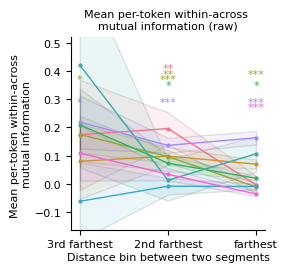

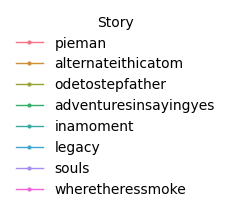

In [53]:
sliding_window_figures_save_dir = os.path.join('/home/jianing/generation/ablation',model_save_dir_name,'sliding_window_ablation','figures')
fig1,legend = plot_difference_line(data_dfs,norm = False)
fig1.savefig(os.path.join(sliding_window_figures_save_dir,'within-across_mean_raw_%dbins.svg'%nbins),transparent = True)
legend.savefig(os.path.join(sliding_window_figures_save_dir,'within-across_mean_raw_legend.svg'),transparent = True)

0it [00:00, ?it/s]

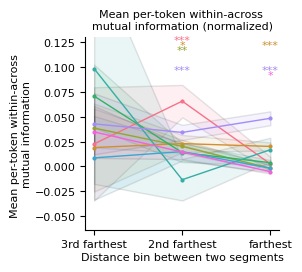

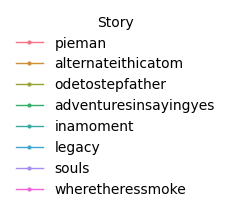

In [49]:
fig1,legend = plot_difference_line(data_dfs_norm,norm = True)
fig1.savefig(os.path.join(sliding_window_figures_save_dir,'within-across_mean_norm_%dbins.svg'%nbins),transparent = True)
legend.savefig(os.path.join(sliding_window_figures_save_dir,'within-across_mean_norm_legend.svg'),transparent = True)